In [1]:
import numpy as np 
np.set_printoptions(threshold=10000,suppress=True) 
import pandas as pd
import warnings
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')

# Mouse

In [2]:
mouse=pd.read_csv("mouse.txt",sep=' ',header=None)

In [3]:
mouse.head()

,0,1
0,0.456601,0.432806
1,0.611378,0.528625
2,0.450299,0.711606
3,0.639015,0.460744
4,0.628957,0.323470


In [4]:
X_mouse=mouse.values

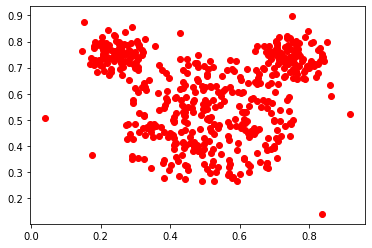

In [5]:
plt.plot(X_mouse[:,0],X_mouse[:,1],'ro')
plt.show()

In [6]:
from sklearn.ensemble import IsolationForest

In [7]:
IF=IsolationForest(n_estimators=500,contamination=0.02,random_state=1)
# contamination : % d'anomalies (ce qu'on croit qu'il y a)
# n_estimators : 500 arbres
IF.fit(X_mouse)
anomalies=IF.predict(X_mouse)

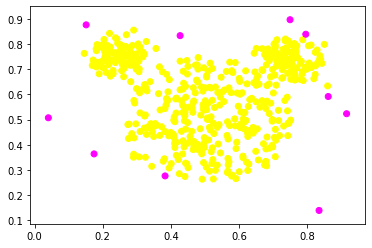

In [8]:
plt.scatter(X_mouse[:,0],X_mouse[:,1],c=anomalies, cmap=plt.get_cmap('spring'))
plt.show()

En prenant 2% d'anomalies, on obtient 10 outliers. (nous savions qu'il y avait 10 anomalies sur 500 valeurs)

Dans le cas où nous ne connaissons pas le nombre d'anomalies (ou son approximation), nous utilisons les scores d'isolements de chaque observations :

In [9]:
IF=IsolationForest(n_estimators=1000,random_state=1)
IF.fit(X_mouse)
decision=IF.decision_function(X_mouse) #renvoie les scores d'isolement de chaque observation

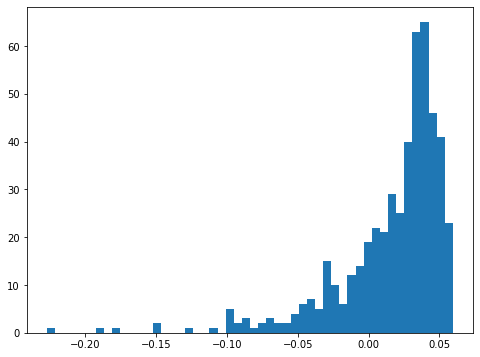

In [10]:
plt.figure(figsize=(8, 6))
plt.hist(decision, bins=50)
plt.show()

On remarque que les anomalies ont des scores inférieurs à -0.10. Ce choix est arbitraire.

In [11]:
anomalie=decision.copy()
anomalie[decision<=-0.1]=0
anomalie[decision>-0.1]=1

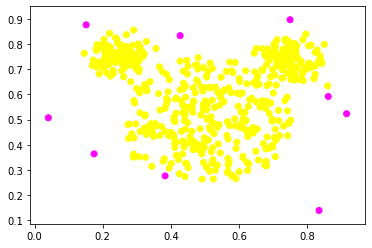

In [12]:
plt.scatter(X_mouse[:,0],X_mouse[:,1],c=anomalie, cmap=plt.get_cmap('spring'))
plt.show()

On a 9 anomalies.

# Fraude

In [13]:
fraude=pd.read_csv("creditcard.csv",sep=',',header=0)

In [14]:
fraude.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
X_fraude=fraude.iloc[:,1:31].values #on enlève la variable Time

In [16]:
Y=X_fraude[:,29] #target

In [17]:
fraudes=X_fraude[Y.astype(int)==1] #on garde les observations des transactions frauduleuses
fraudes.shape

(492, 30)

In [18]:
nonfraudes=X_fraude[Y.astype(int)==0] #on garde les observations des transactions non frauduleuses
nonfraudes.shape

(284315, 30)

In [19]:
np.random.seed(1) #pour toujours avoir le même sample si on relance les cellules

In [20]:
# On prend 20000 observations parmis toutes les observations non frauduleuses
random_indices = np.arange(0, nonfraudes.shape[0])
np.random.shuffle(random_indices)
sample=nonfraudes[random_indices[:20000]]
sample.shape

(20000, 30)

In [21]:
# jeu de donnees contenant toutes les transactions frauduleuses et les 20000 non frauduleuses prises aleatoirement
jeu=np.vstack((sample,fraudes)) 
jeu.shape

(20492, 30)

In [22]:
jeualgo=jeu[:,:29] # On supprime la colonne CLASS pour ne pas la prendre en compte dans l'algo

In [23]:
IF=IsolationForest(n_estimators=500,contamination=0.024,random_state=1)
# contamination : % d'anomalies (ici 492/20492=2.4%)
# n_estimators : 500 arbres
IF.fit(jeualgo)
anomalies=IF.predict(jeualgo)

In [24]:
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score,recall_score

In [25]:
ypred=anomalies.astype(int)
ypred[ypred==1]=0
ypred[ypred==-1]=1

In [26]:
ytest=jeu[:,29].astype(int)

In [27]:
print("Matrice de confusion")
print(confusion_matrix(ytest,ypred),"\n")
print("Accuracy : {0:.3f}%".format(accuracy_score(ytest,ypred)*100))
print("Precision : {0:.3f}%".format(precision_score(ytest,ypred)*100))
print("Recall : {0:.3f}%".format(recall_score(ytest,ypred)*100))

Matrice de confusion
[[19788   212]
 [  212   280]] 

Accuracy : 97.931%
Precision : 56.911%
Recall : 56.911%


La fonction de scoring qui correspond le mieux à notre problème est le recall. En effet, on préfère déceler le maximum de fraudes possibles. On va donc minimiser le nombre de fraudes qui passent entre les mailles du filet (le nombre de fraudes qui sont considérées comme non-fraudes). Cela risquerait par conséquent d'augmenter le nombre de False Positive (le nombre de transactions "normales" qui sont détectées comme fraudes. Si on prend la précision, cela risquerait d'augmenter le nombre de False Negative (le nombre de transactions frauduleuses qui sont détectées comme "normales").

Ici, le recall est équivalent à la précision vu qu'on a autant de False Negative que de False Positive. Cependant, ici nous connaissions le nombre de fraudes réelles et nous avons par conséquent entré un paramètre de contamination. Pour augmenter le recall, nous pourrions augmenter le paramètre de contamination.

Nous pouvons donc utiliser la même méthode que pour la première partie du TP, à savoir en choisissant arbitrairement un seuil sur le score d'isolement, pour lequel on va prédire si oui ou non la transaction est frauduleuse. Il est plus simple de choisir un seuil grâce à l'histogramme que de choisir un taux d'anomalies arbitrairement.

In [28]:
IF=IsolationForest(n_estimators=500,random_state=1)
# contamination : % d'anomalies (ici 492/20492=2.4%)
# n_estimators : 500 arbres
IF.fit(jeualgo)
decision=IF.decision_function(jeualgo) #renvoie les scores d'isolement de chaque observation

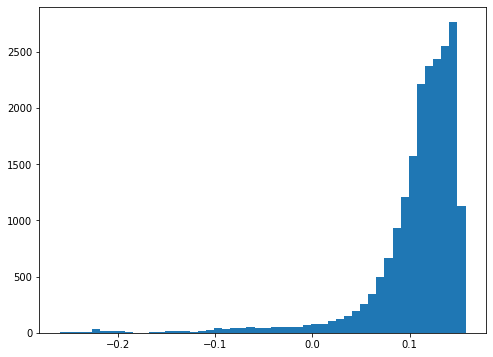

In [29]:
plt.figure(figsize=(8, 6))
plt.hist(decision, bins=50)
plt.show()

In [30]:
anomalie=decision.copy()
anomalie[decision<=0.05]=1
anomalie[decision>0.05]=0

In [31]:
ytest=jeu[:,29].astype(int)
ypred=anomalie.astype(int)

In [32]:
print(confusion_matrix(ytest,ypred))
print("Accuracy : {0:.3f}%".format(accuracy_score(ytest,ypred)*100))
print("Precision : {0:.3f}%".format(precision_score(ytest,ypred)*100))
print("Recall : {0:.3f}%".format(recall_score(ytest,ypred)*100))

[[18849  1151]
 [   72   420]]
Accuracy : 94.032%
Precision : 26.735%
Recall : 85.366%


En jouant sur le seuil de score d'isolement (pour lequel on va dire si l'observation est une fraude ou non), on peut gagner en recall (au détriment de la précision) si on choisi un seuil plus élevé.
En choisissant un seuil à 0.05, nous obtenons jusqu'à 85% de recall, avec toujours une accuracy assez bonne (93.6%). Autrement dit, nous avons détecté 85% des fraudes réelles.